In [1]:
import numpy as np
import os
import subprocess as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.ticker import StrMethodFormatter
import sys

In [2]:
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

In [3]:
def gettingFacets(filename,includeCoat='true'):
    exe = ["./getFacet-threePhase", filename, includeCoat]
    p = sp.Popen(exe, stdout=sp.PIPE, stderr=sp.PIPE)
    stdout, stderr = p.communicate()
    temp1 = stderr.decode("utf-8")
    temp2 = temp1.split("\n")
    segs = []
    skip = False
    if (len(temp2) > 1e2):
        for n1 in range(len(temp2)):
            temp3 = temp2[n1].split(" ")
            if temp3 == ['']:
                skip = False
                pass
            else:
                if not skip:
                    temp4 = temp2[n1+1].split(" ")
                    r1, z1 = np.array([float(temp3[1]), float(temp3[0])])
                    r2, z2 = np.array([float(temp4[1]), float(temp4[0])])
                    segs.append(((r1, z1),(r2, z2)))
                    segs.append(((-r1, z1),(-r2, z2)))
                    skip = True
    return segs

In [4]:
def gettingfield(filename, zmin, zmax, rmax, nr, Oh1, Oh2, Oh3):
    exe = ["./getData-elastic", filename, str(zmin), str(0), str(zmax), str(rmax), str(nr), str(Oh1), str(Oh2), str(Oh3)]
    p = sp.Popen(exe, stdout=sp.PIPE, stderr=sp.PIPE)
    stdout, stderr = p.communicate()
    temp1 = stderr.decode("utf-8")
    temp2 = temp1.split("\n")
    # print(temp2) #debugging
    Rtemp, Ztemp, D2temp, veltemp, Utemp, Vtemp, taupTemp = [],[],[],[],[],[],[]

    for n1 in range(len(temp2)):
        temp3 = temp2[n1].split(" ")
        if temp3 == ['']:
            pass
        else:
            Ztemp.append(float(temp3[0]))
            Rtemp.append(float(temp3[1]))
            D2temp.append(float(temp3[2]))
            veltemp.append(float(temp3[3]))
            taupTemp.append(float(temp3[4]))

    R = np.asarray(Rtemp)
    Z = np.asarray(Ztemp)
    D2 = np.asarray(D2temp)
    vel = np.asarray(veltemp)
    taup = np.asarray(taupTemp)
    nz = int(len(Z)/nr)

    # print("nr is %d %d" % (nr, len(R))) # debugging
    print("nz is %d" % nz)

    R.resize((nz, nr))
    Z.resize((nz, nr))
    D2.resize((nz, nr))
    vel.resize((nz, nr))
    taup.resize((nz, nr))

    return R, Z, D2, vel, taup, nz

In [10]:
place = "intermediate/snapshot-%5.4f" % 0.10

In [11]:
segs1 = gettingFacets(place)
segs2 = gettingFacets(place,'false')

In [12]:
Ldomain = 8
GridsPerR = 100
nr = int(GridsPerR*Ldomain)
Oh1, Oh2, Oh3 = 0.017, 0.017/3.3, 0.017*1e-2

rmin, rmax, zmin, zmax = [-Ldomain/2, Ldomain/2, -2.0, Ldomain-2.0]
R, Z, taus, vel, taup, nz = gettingfield(place, zmin, zmax, rmax, nr, Oh1, Oh2, Oh3)
zminp, zmaxp, rminp, rmaxp = Z.min(), Z.max(), R.min(), R.max()

nz is 1600


(-4.0, 4.0, -2.0, 6.0)

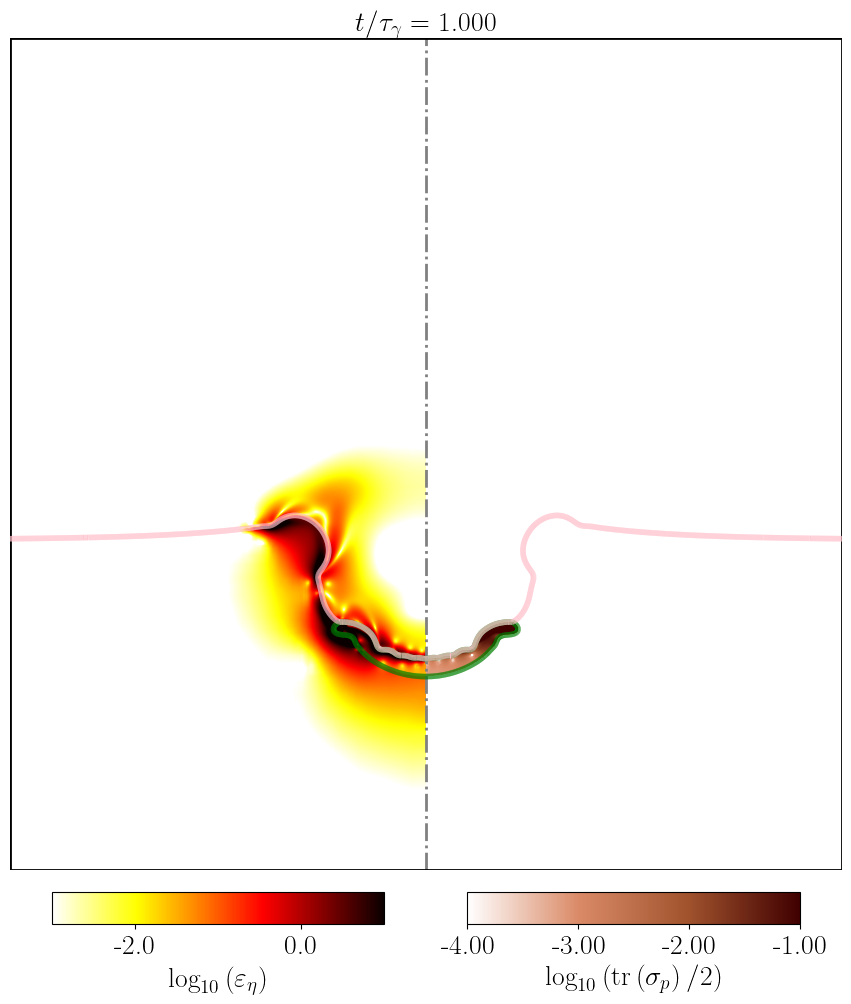

In [13]:
import matplotlib.colors as mcolors
custom_colors = ["white", "#DA8A67", "#A0522D", "#400000"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_hot", custom_colors)

lw = 2
AxesLabel, TickLabel = [50, 20]
fig, ax = plt.subplots()
fig.set_size_inches(19.20, 10.80)

ax.plot([0, 0], [zmin, zmax],'-.',color='grey',linewidth=lw)

ax.plot([rmin, rmin], [zmin, zmax],'-',color='black',linewidth=lw)
ax.plot([rmin, rmax], [zmin, zmin],'-',color='black',linewidth=lw)
ax.plot([rmin, rmax], [zmax, zmax],'-',color='black',linewidth=lw)
ax.plot([rmax, rmax], [zmin, zmax],'-',color='black',linewidth=lw)

## Drawing Facets
line_segments = LineCollection(segs2, linewidths=4, colors='green', linestyle='solid')
ax.add_collection(line_segments)
line_segments = LineCollection(segs1, linewidths=4, colors='pink', linestyle='solid')
ax.add_collection(line_segments)

cntrl1 = ax.imshow(taus, cmap="hot_r", interpolation='Bilinear', origin='lower', extent=[-rminp, -rmaxp, zminp, zmaxp], vmax=1.0, vmin=-3.0)
cntrl2 = ax.imshow(taup, interpolation='Bilinear', cmap=custom_cmap, origin='lower', extent=[rminp, rmaxp, zminp, zmaxp], vmax=-1.0, vmin=-4.0)


ax.set_aspect('equal')
ax.set_xlim(rmin, rmax)
ax.set_ylim(zmin, zmax)
# t2 = t/tc
ax.set_title('$t/\\tau_\gamma$ = %4.3f' % 1, fontsize=TickLabel)

l, b, w, h = ax.get_position().bounds
cb1 = fig.add_axes([l+0.05*w, b-0.05, 0.40*w, 0.03])
c1 = plt.colorbar(cntrl1,cax=cb1,orientation='horizontal')
c1.set_label(r'$\log_{10}\left(\varepsilon_\eta\right)$',fontsize=TickLabel, labelpad=5)
c1.ax.tick_params(labelsize=TickLabel)
c1.ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
cb2 = fig.add_axes([l+0.55*w, b-0.05, 0.40*w, 0.03])
c2 = plt.colorbar(cntrl2,cax=cb2,orientation='horizontal')
c2.ax.tick_params(labelsize=TickLabel)
c2.set_label(r'$\log_{10}\left(\text{tr}\left(\sigma_p\right)/2\right)$',fontsize=TickLabel)
c2.ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
ax.axis('off')